In [27]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import time
from models import VGG16, ResNet50

In [28]:
from tensorflow.keras.applications.vgg16 import VGG16		# VGG16 모델

model_VGG16 = VGG16(weights='imagenet')

In [29]:
from tensorflow.keras.applications.resnet import ResNet50

model_RESNET50 = ResNet50(weights='imagenet')

In [30]:
# 데이터 준비
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms.ToTensor())
testloader = DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [31]:
# 디바이스 설정
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu") #for mac

print(f"Using device: {device}")

print(f"Train dataset size: {len(trainset)}")
print(f"Test dataset size: {len(testset)}")


Using device: mps
Train dataset size: 50000
Test dataset size: 10000


In [32]:
# 시각화
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [33]:
# 클래스 레이블
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.4714162].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.47332823..1.7764271].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5161401..1.6244541].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.46533608..1.453987].


<function matplotlib.pyplot.show(close=None, block=None)>

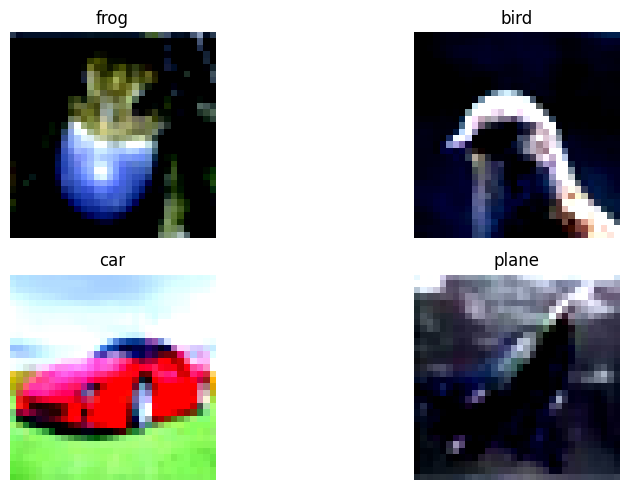

In [34]:
# 이미지 표시 함수
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')

# 랜덤한 이미지 가져오기
detaiter = iter(trainloader)
images, labels = next(detaiter)

# 이미지 그리드 생성 및 표시
fig = plt.figure(figsize=(10, 5))
for i in range(4):
    ax = fig.add_subplot(2, 2, i+1, xticks=[], yticks=[])
    imshow(images[i])
    ax.set_title(classes[labels[i]])

plt.tight_layout()
plt.show

Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.4558606..1.8382572].


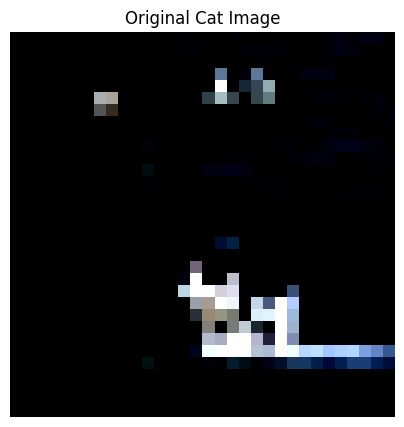

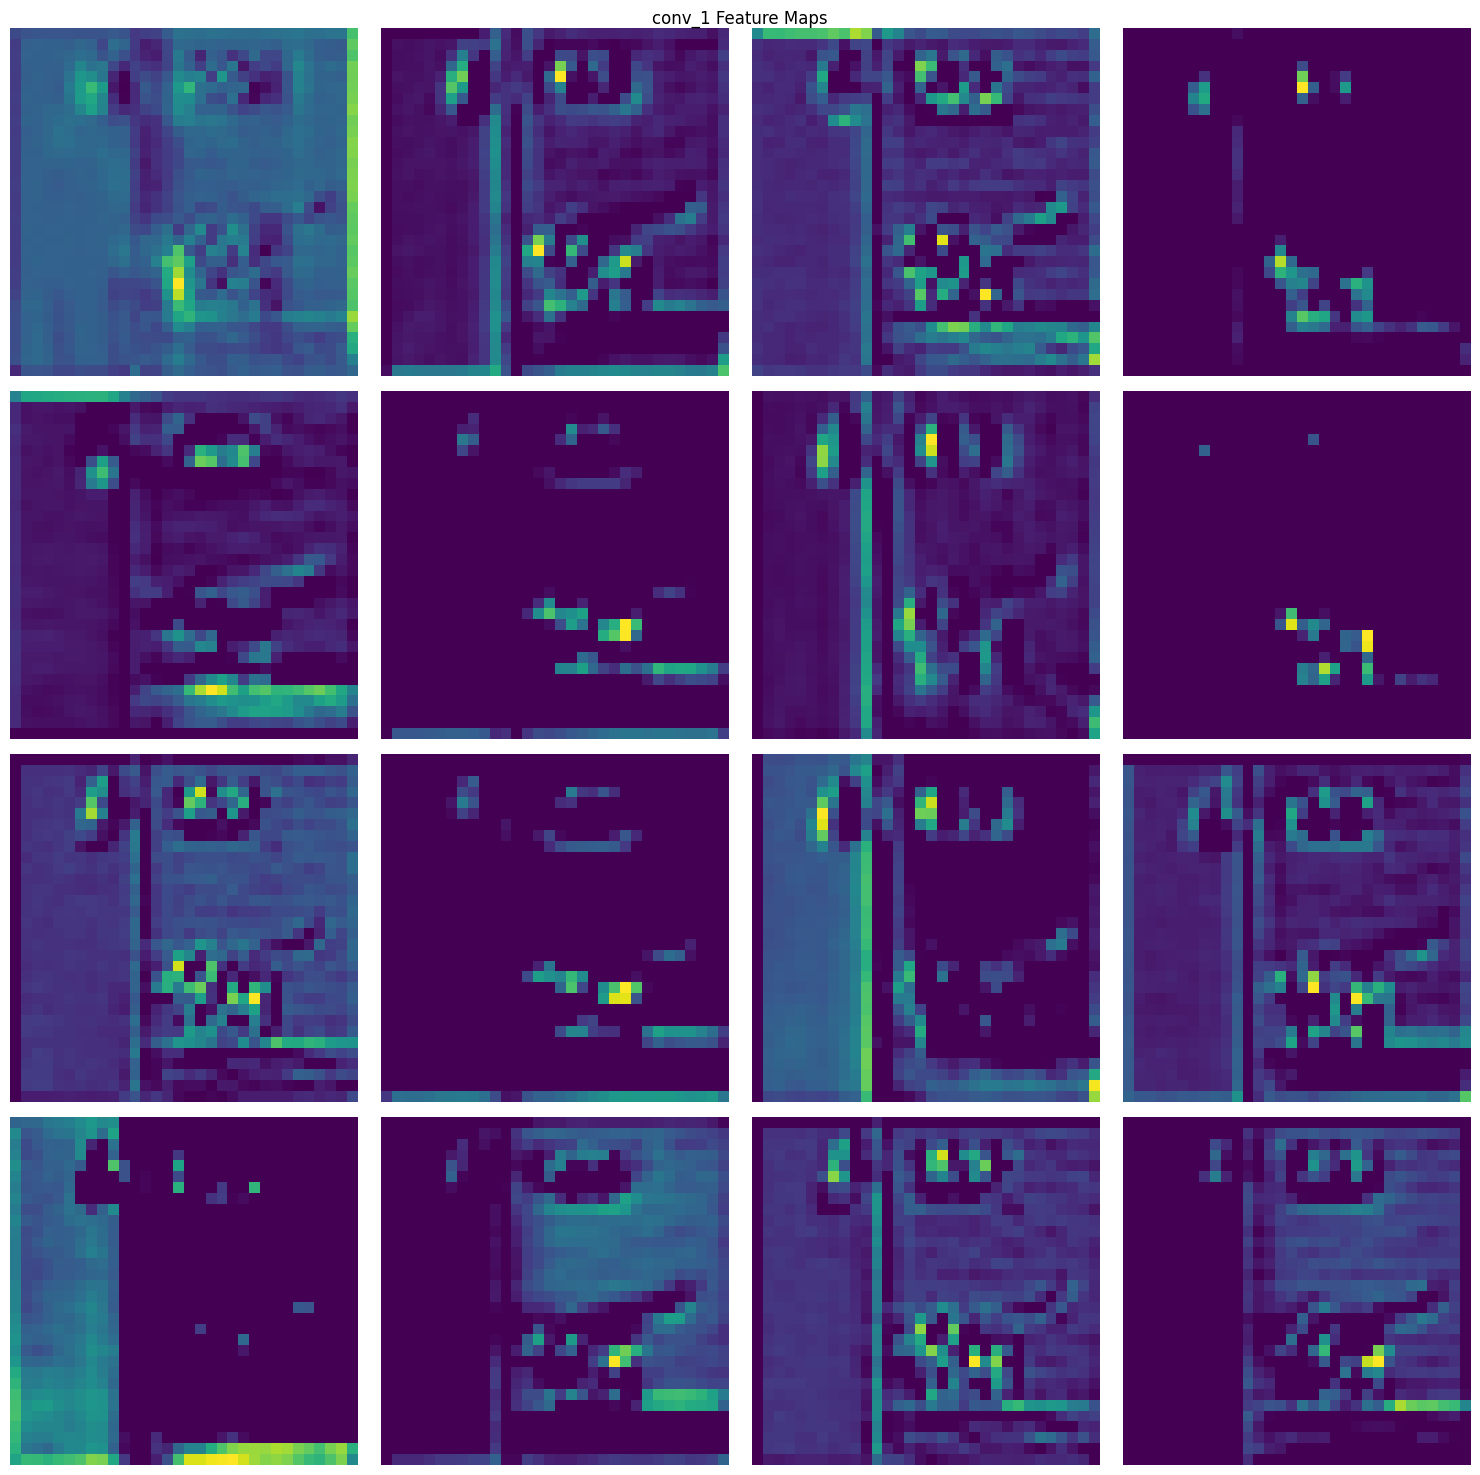

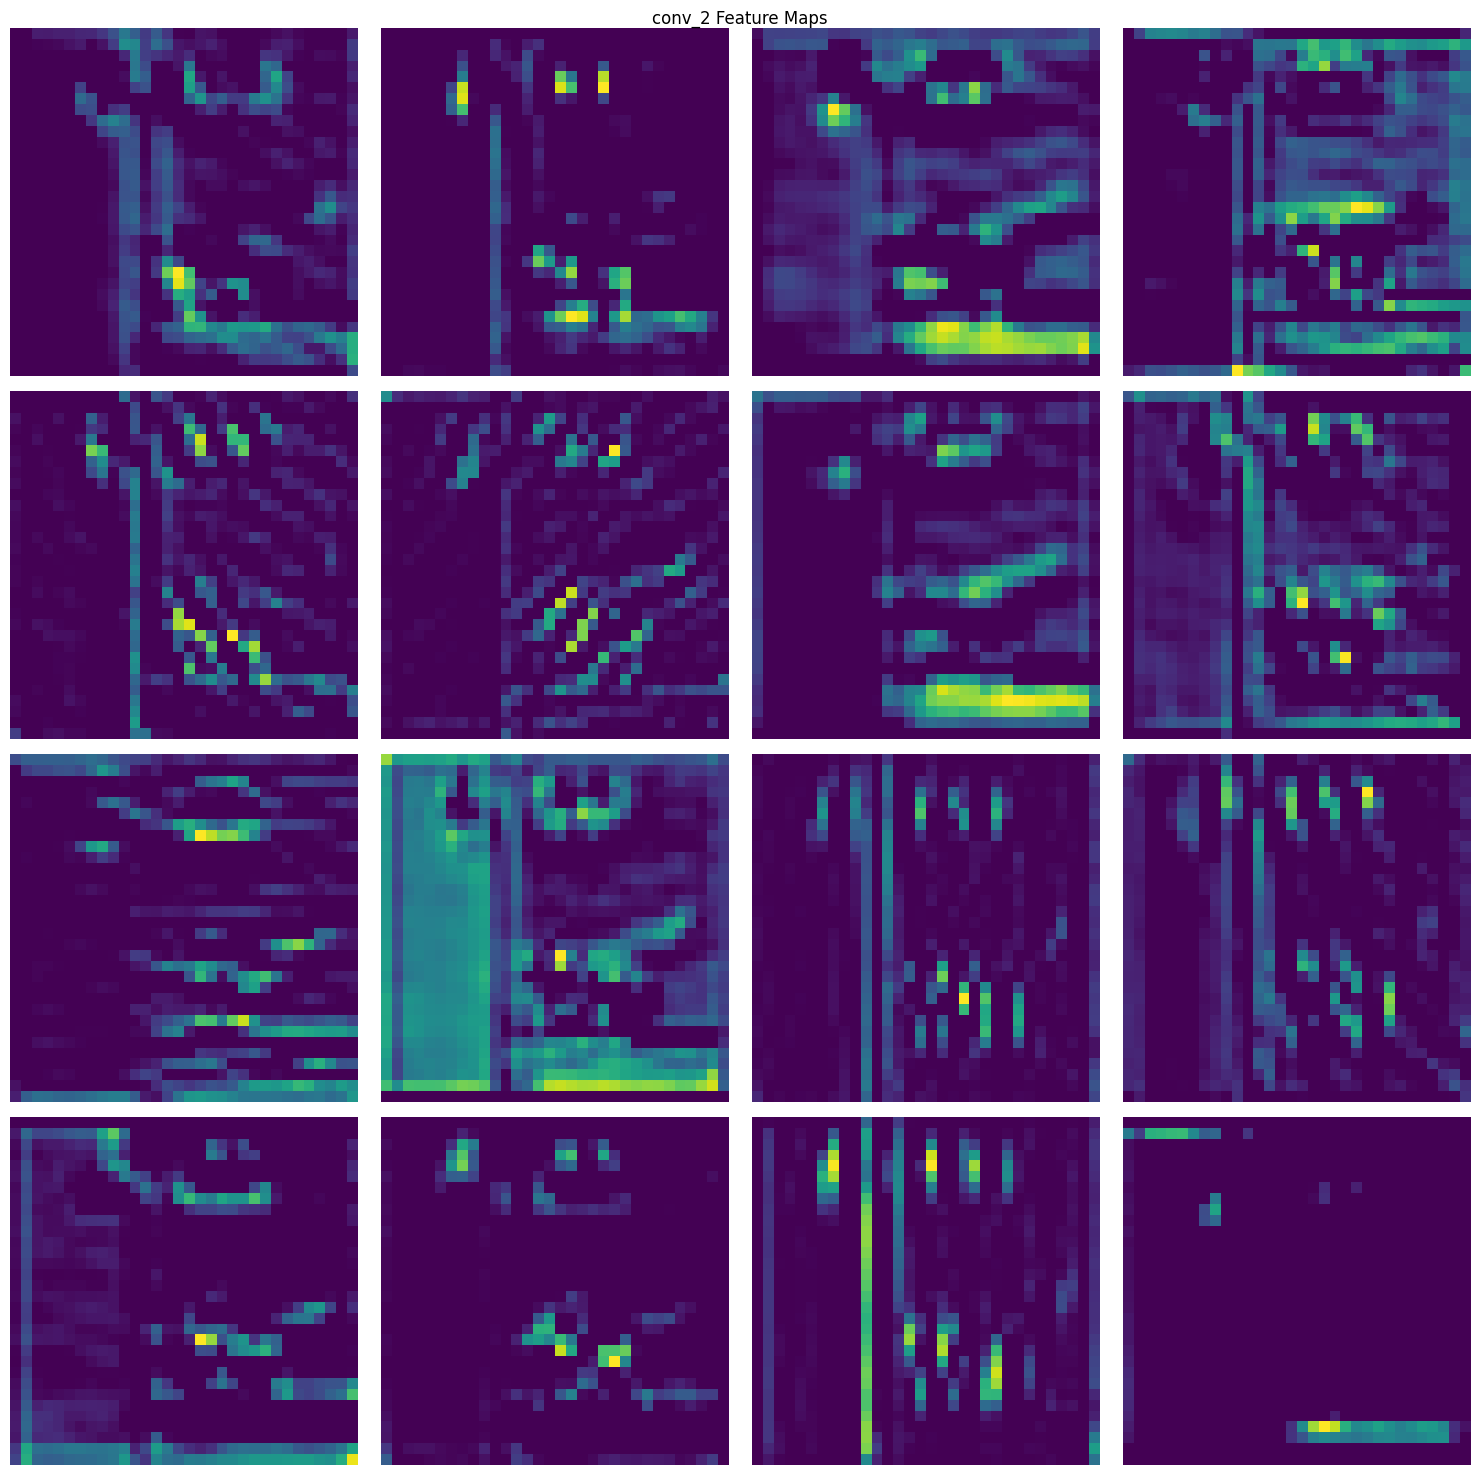

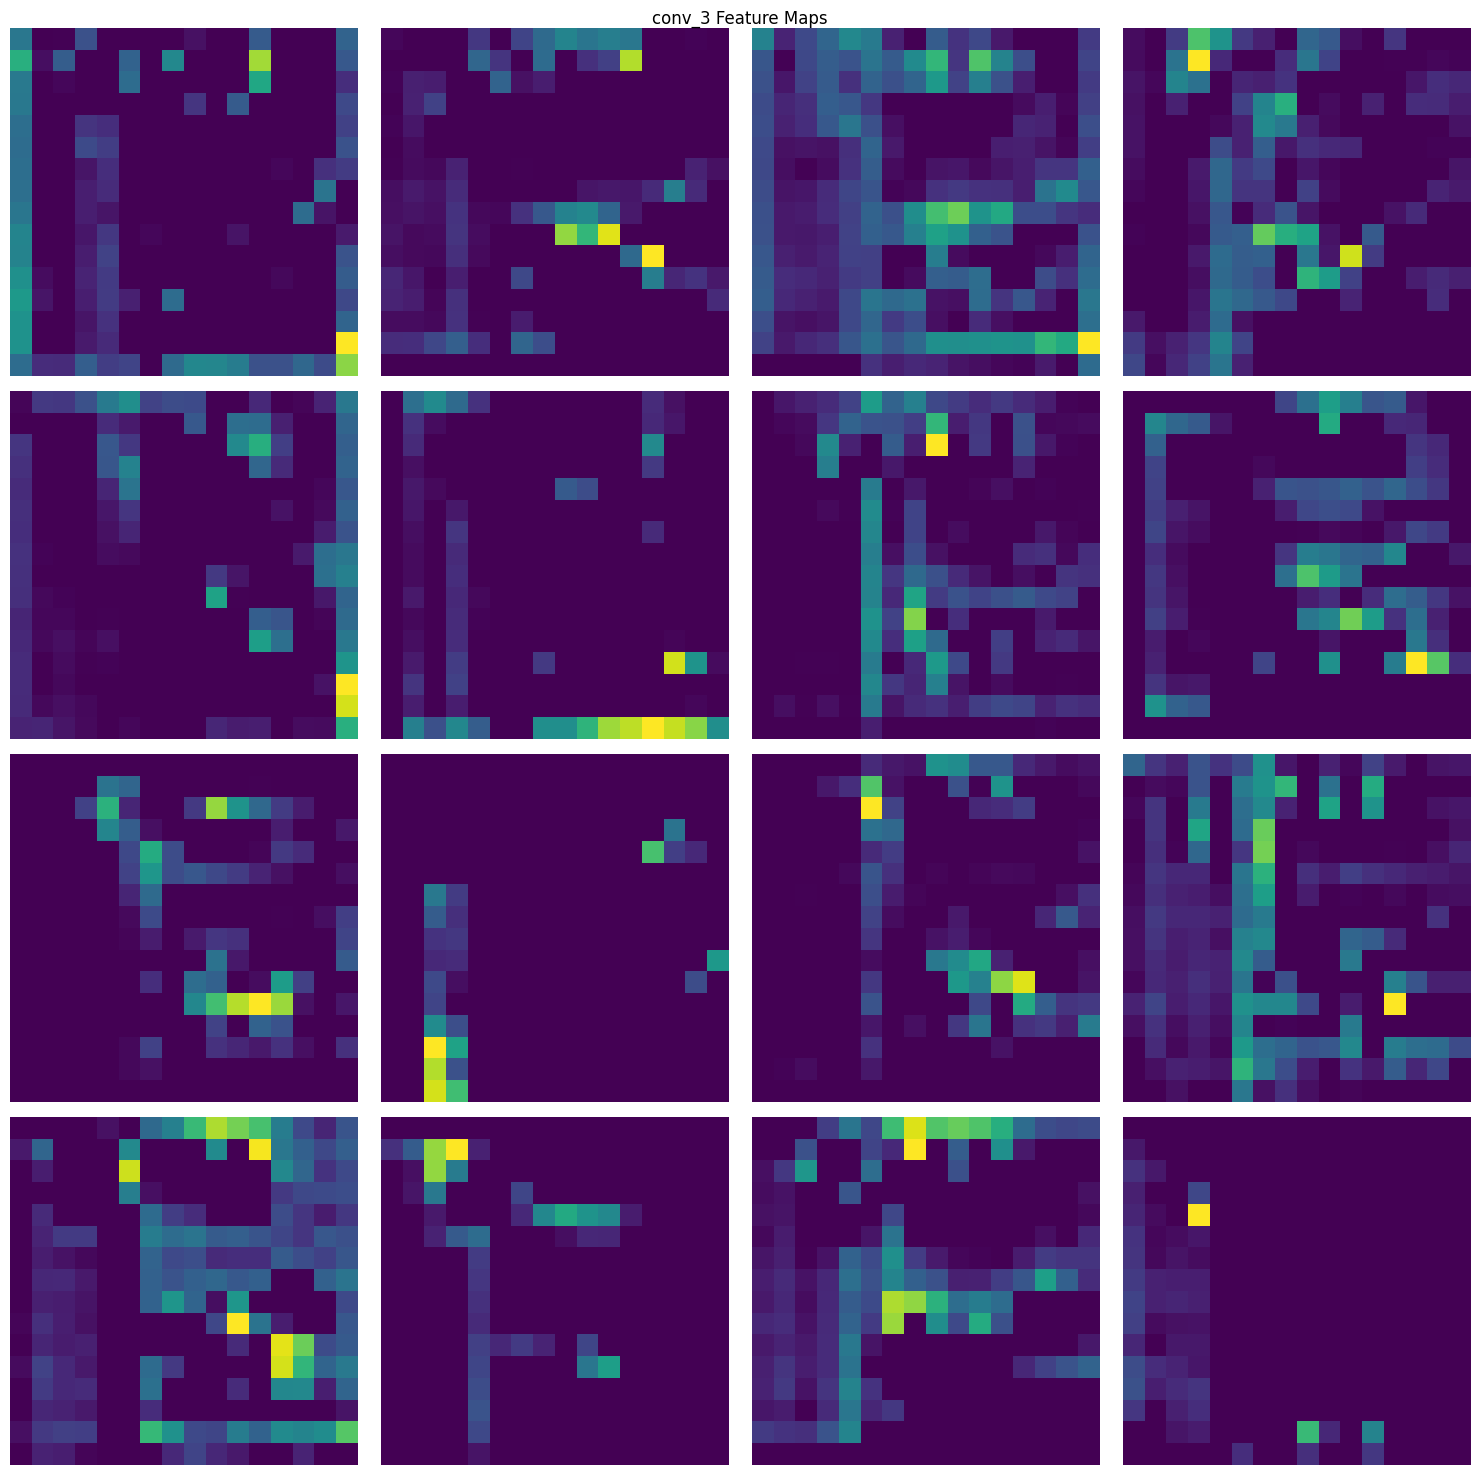

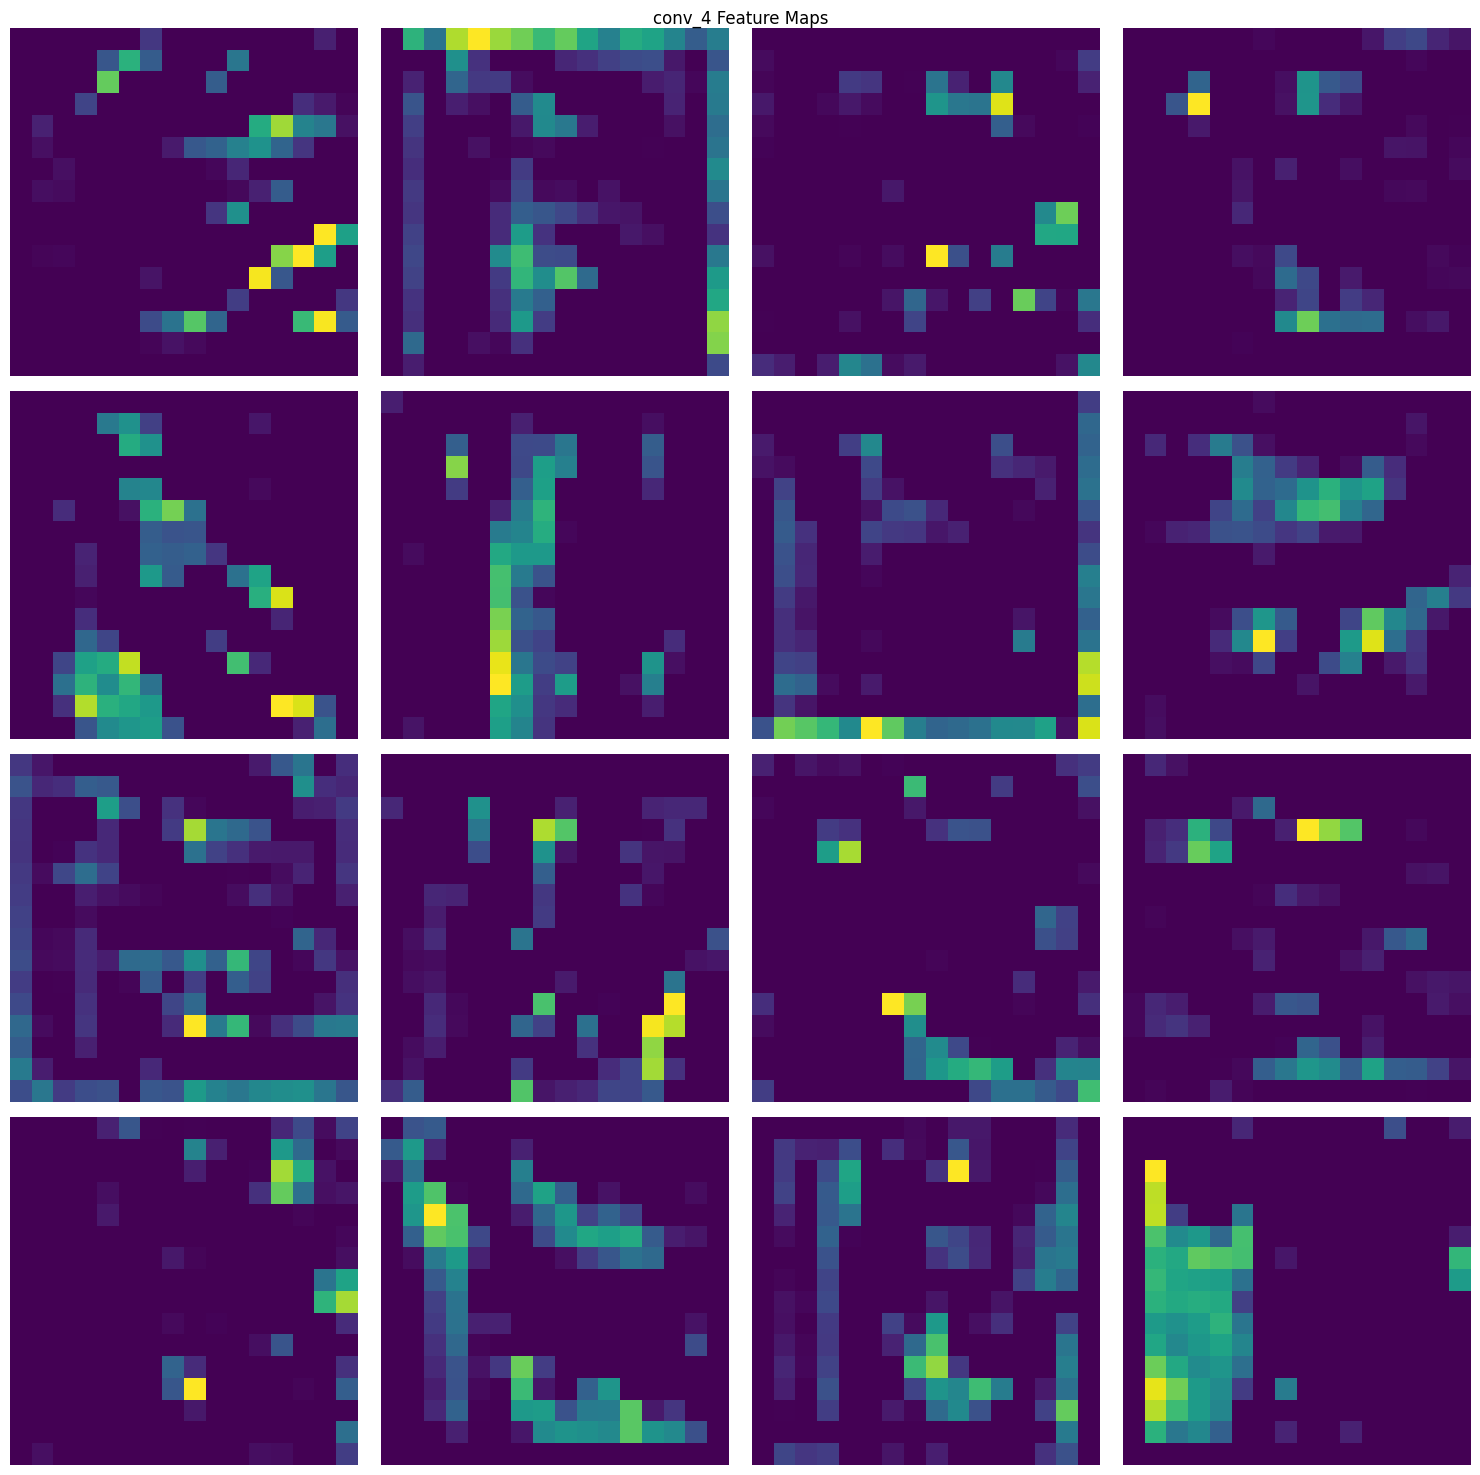

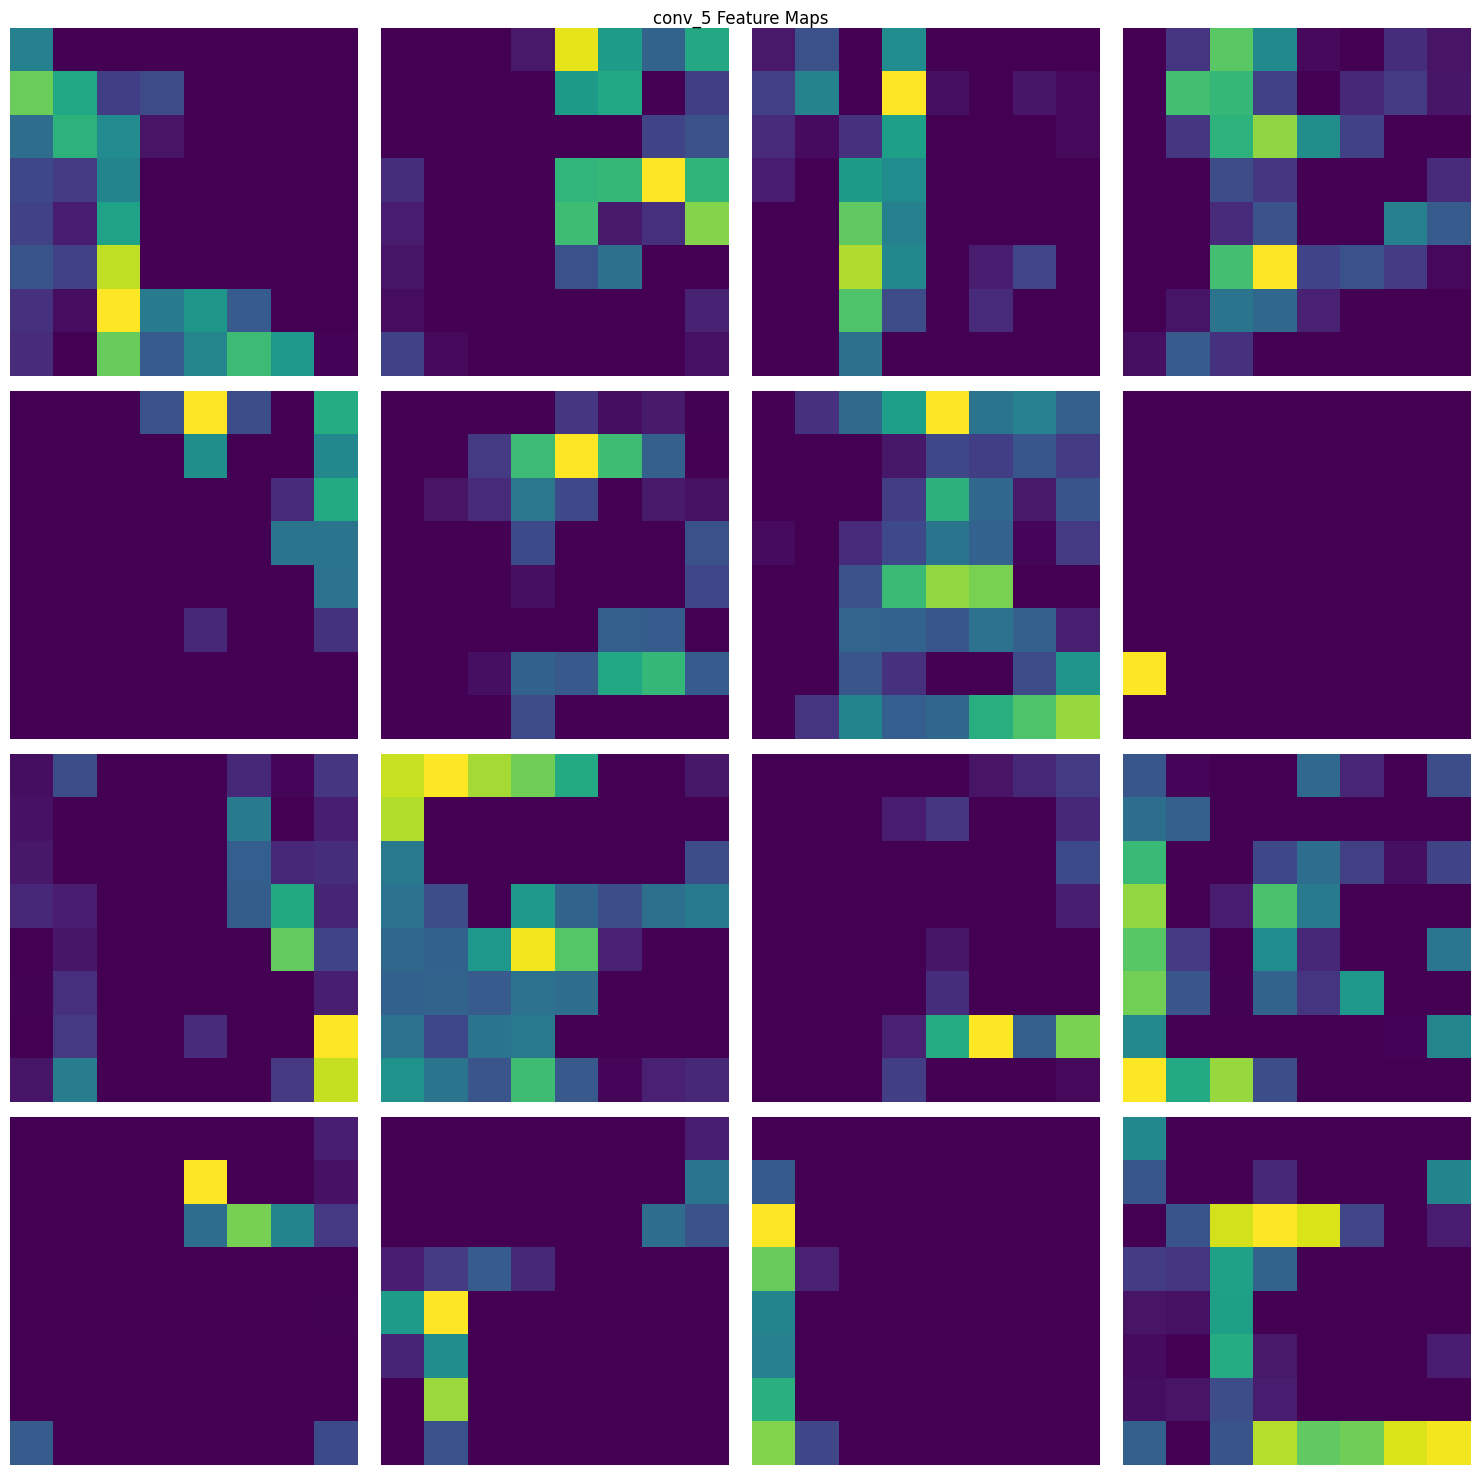

In [35]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch import nn
from torchvision.models import vgg16, VGG16_Weights

# CIFAR-10 데이터셋 로드
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet 정규화
])
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

# 클래스 레이블
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# 디바이스 설정
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

def extract_feature_maps_vgg16(model, image):
    feature_maps = {}
    x = image
    
    for i, block in enumerate(model.features):
        x = block(x)
        if isinstance(block, nn.Conv2d):
            feature_maps[f"conv_{len(feature_maps)+1}"] = x
    
    return feature_maps

def visualize_feature_maps(feature_maps, layer_name):
    feature_map = feature_maps[layer_name].squeeze(0).detach().cpu().numpy()
    num_features = min(16, feature_map.shape[0])
    fig, axes = plt.subplots(4, 4, figsize=(15, 15))
    for i in range(num_features):
        ax = axes[i//4, i%4]
        ax.imshow(feature_map[i], cmap='viridis')
        ax.axis('off')
    plt.suptitle(f"{layer_name} Feature Maps")
    plt.tight_layout()
    plt.show()

# 고양이 이미지 인덱스 찾기
cat_indices = [i for i, (_, label) in enumerate(testset) if label == 3]  # 3은 CIFAR-10에서 고양이 클래스의 인덱스입니다
random_cat_index = np.random.choice(cat_indices)

# 임의의 고양이 이미지 선택
image, _ = testset[random_cat_index]
image = image.unsqueeze(0).to(device)  # 배치 차원 추가 및 디바이스로 이동

# 원본 이미지 시각화
plt.figure(figsize=(5, 5))
plt.imshow(image.squeeze().permute(1, 2, 0).cpu().numpy())
plt.title("Original Cat Image")
plt.axis('off')
plt.show()

# Pre-trained VGG16 모델 로드
vgg16 = vgg16(weights=VGG16_Weights.IMAGENET1K_V1)
vgg16 = vgg16.to(device)
vgg16.eval()

# Feature maps 추출
feature_maps = extract_feature_maps_vgg16(vgg16, image)

# conv_1부터 conv_5까지의 feature map 시각화
for i in range(1, 6):
    layer_name = f"conv_{i}"
    visualize_feature_maps(feature_maps, layer_name)

In [36]:
import torch
import torch.nn as nn
from torchsummary import summary
"""
nn.Sequential
nn.Conv2d
nn.AvgPool2d
nn.Linear
"""
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        self.feature = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Conv2d(6, 16, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 120, kernel_size=5, stride=1),
            nn.Tanh(),
        )
        self.classifier = nn.Sequential(
            nn.Linear(120, 84),
            nn.Tanh(),
            nn.Linear(84, 10),
        )
    def forward(self, x):
        x = self.feature(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x
model = LeNet5()
print(model)

from torchsummary import summary
summary(model, (1,32,32))

LeNet5(
  (feature): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): Tanh()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): Tanh()
    (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (6): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
    (7): Tanh()
  )
  (classifier): Sequential(
    (0): Linear(in_features=120, out_features=84, bias=True)
    (1): Tanh()
    (2): Linear(in_features=84, out_features=10, bias=True)
  )
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             156
              Tanh-2            [-1, 6, 28, 28]               0
         AvgPool2d-3            [-1, 6, 14, 14]               0
            Conv2d-4           [-1, 16, 10, 10]           2,416
              Tanh-5           [-1, 16, 10, 10]               0
         A

In [37]:
class VGG16_v1(nn.Module):
    def __init__(self, num_classes=1000):
        super(VGG16_v1, self).__init__()
        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # Block 3
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # Block 4
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # Block 5
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )
    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x
class VGG16(nn.Module):
    def __init__(self, num_classes=1000):
        super(VGG16, self).__init__()
        self.features = nn.Sequential(
            self._make_layers(3, 64, 2),
            self._make_layers(64, 128, 2),
            self._make_layers(128, 256, 3),
            self._make_layers(256, 512, 3),
            self._make_layers(512, 512, 3)
        )
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )
    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x
    def _make_layers(self, in_channels, out_channels, conv_layers):
        layers = []
        for _ in range(conv_layers):
            layers += [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                       nn.BatchNorm2d(out_channels),
                       nn.ReLU(inplace=True)]
            in_channels = out_channels
        layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        return nn.Sequential(*layers)